In [ ]:
!pip3 install torch torchvision torchaudio torchviz

In [ ]:
import os
import pickle
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import json
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
import google.colab
from google.colab import files

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/',
                                       download = True,
                                       train = True,
                                       transform = transform)
test_set_orig = datasets.FashionMNIST('MNIST_data/',
                                       download = True,
                                       train = False,
                                       transform = transform)

##PARTE 1

In [ ]:
class Autoencoder(nn.Module):
    """
    Combina el encoder, el linear_layer y el decoder en una sola red neuronal.
    """
    def __init__(self, n: int, p: float):
        """
        Constructor de la clase Autoencoder.

        Parámetros:
        - n (int): Número de neuronas en la capa lineal intermedia.
        """
        super(Autoencoder, self).__init__()
        # Codificador (Encoder)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),  # Conv2d: (1, 28, 28) -> (16, 26, 26)
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.MaxPool2d(kernel_size=2)  # MaxPool2d: (16, 26, 26) -> (16, 13, 13)
        )

        # Calcula el tamaño después del encoder
        self.encoder_output_shape = 16*13*13

        # Capas lineales con tamaño n
        self.linear_layer = nn.Sequential(
            nn.Flatten(),  # Aplana la entrada
            nn.Linear(self.encoder_output_shape, n),  # Reduce al tamaño n
            nn.ReLU(),                                #PREGUNTARRRRRRRR!!!!!
            nn.Dropout(p=p),                          #PREGUNTARRRRRRRR!!!!!
            nn.Linear(n, self.encoder_output_shape),  # Reconstruye al tamaño original
            nn.ReLU()
        )

        # Decodificador (Decoder)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=16,
                out_channels=1,
                kernel_size=6,
                stride=2,
                padding=1,
                output_padding=0
            ),  # ConvTranspose2d: (16, 13, 13) -> (1, 28, 28)
            nn.Sigmoid()  # Limita la salida al rango [0, 1]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define el flujo de datos a través de la red.

        Parámetros:
        - x (torch.Tensor): Tensor de entrada con forma (batch_size, 1, 28, 28).

        Retorno:
        - torch.Tensor: Tensor de salida con forma (batch_size, 1, 28, 28).
        """
        # Paso por el encoder
        encoded = self.encoder(x)

        # Paso por la capa lineal
        linear_output = self.linear_layer(encoded)

        # Reconstrucción: adaptamos el tensor para el decoder
        batch_size = x.size(0)
        decoded_input = linear_output.view(batch_size, 16, 13, 13)  # Volvemos al tamaño esperado por el decoder

        # Paso por el decoder
        decoded = self.decoder(decoded_input)
        return decoded


##PARTE 2

In [ ]:
def train_error(model, train_loader, criterion, device):
    """
    Calcula la pérdida promedio en el conjunto de entrenamiento sin realizar backpropagation.

    Parámetros:
    - model: Modelo a evaluar.
    - train_loader: DataLoader para el conjunto de entrenamiento.
    - criterion: Función de pérdida.
    - device: Dispositivo (CPU o GPU) donde se ejecutará el modelo.

    Retorno:
    - avg_loss (float): Pérdida promedio en el conjunto de entrenamiento.
    """
    model.eval()  # Poner la red en modo de evaluación
    total_loss = 0

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)  # Paso hacia adelante
            loss = criterion(output, target)  # Calcular la pérdida
            total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss


def train_loop(model, train_loader, criterion, optimizer, device):
    """
    Realiza un ciclo de entrenamiento sobre el conjunto de datos.

    Parámetros:
    - model: Modelo a entrenar.
    - train_loader: DataLoader para el conjunto de entrenamiento.
    - criterion: Función de pérdida.
    - optimizer: Optimizador para actualizar los parámetros del modelo.
    - device: Dispositivo (CPU o GPU) donde se ejecutará el modelo.

    Retorno:
    - avg_loss (float): Pérdida promedio en el conjunto de entrenamiento tras esta época.
    """
    model.train()  # Poner la red en modo de entrenamiento

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Limpiar gradientes previos
        output = model(data)  # Paso hacia adelante
        loss = criterion(output, target)  # Calcular la pérdida
        loss.backward()  # Paso hacia atrás
        optimizer.step()  # Actualizar los parámetros

    avg_loss = train_error(model, train_loader, criterion, device)
    return avg_loss

def valid_loop(model, valid_loader, criterion, device):
    model.eval()  # Poner la red en modo de evaluación
    total_loss = 0
    correct = 0

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)  # Paso hacia adelante
            loss = criterion(output, target)  # Calcular la pérdida

            total_loss += loss.item()

    avg_loss = total_loss / len(valid_loader)

    return avg_loss

In [ ]:
class CustomDataset(Dataset):
    """
    Clase personalizada derivada de torch.utils.data.Dataset para transformar el
    dataset FashionMNIST a un formato pensado para entrenar un autoencoder.

    En lugar de retornar (imagen, etiqueta), retorna (imagen, imagen).
    """
    def __init__(self, dataset: Dataset):
        """
        Constructor de la clase CustomDataset.

        Parámetros:
        - dataset (Dataset): Dataset base (por ejemplo, FashionMNIST) que se va a transformar.
        """
        self.dataset = dataset

    def __len__(self) -> int:
        """
        Retorna la cantidad de muestras en el dataset.

        Retorno:
        - int: Longitud del dataset.
        """
        return len(self.dataset)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Retorna la i-ésima muestra del dataset como un par (input, output),
        donde ambos son iguales a la i-ésima imagen.

        Parámetros:
        - index (int): Índice de la muestra.

        Retorno:
        - tuple[torch.Tensor, torch.Tensor]: Par (imagen, imagen).
        """
        image, _ = self.dataset[index]  # Ignorar el label original
        return image, image

In [ ]:
# Transformar a datasets para autoencoder usando CustomDataset
train_set_autoencoder = CustomDataset(train_set_orig)
test_set_autoencoder = CustomDataset(test_set_orig)

#Haciendo los loaders
train_loader = DataLoader(dataset=train_set_autoencoder, batch_size=100, shuffle=True)
valid_loader = DataLoader(dataset=test_set_autoencoder, batch_size=100, shuffle=True)

In [ ]:
# Crear el modelo
n = 200
model = Autoencoder(n=n, p=0.2)

In [ ]:
# Definir la función de pérdida
criterion = nn.MSELoss()

learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Modelo trabajando en: {device}")

Modelo trabajando en: cuda


n = 200
p = 0.2
lr = 0.0001
MSE
Adam
Batch size = 100
epochs = 30

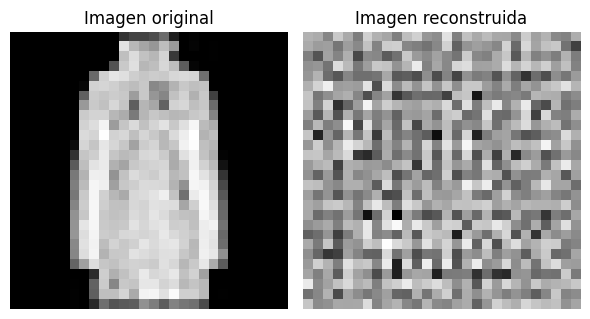

In [ ]:
# Obtener una imagen aleatoria del train_loader
data_iter = iter(train_loader)  # Crear un iterador del DataLoader
images, labels = next(data_iter)  # Obtener un batch de imágenes y etiquetas

# Seleccionar una imagen aleatoria dentro del batch
import random
random_idx = random.randint(0, images.size(0) - 1)  # Índice aleatorio dentro del batch
image = images[random_idx]  # Imagen aleatoria
label = labels[random_idx]  # Etiqueta correspondiente

# Mover la imagen a la GPU si es necesario
image = image.to(device)  # Asegurarse de que la imagen esté en el mismo dispositivo que el modelo

# Agregar el canal batch para pasarlo al modelo
image_with_channel = image.unsqueeze(0)

# Inferencia con el modelo
output_tensor = model(image_with_channel)
output_image = output_tensor.detach().cpu().squeeze(0)  # Llevar a la CPU y eliminar el batch dimension

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Imagen original
axes[0].imshow(image.cpu().squeeze(), cmap="Greys_r")  # Llevar a la CPU para visualización
axes[0].axis("off")
axes[0].set_title("Imagen original")

# Imagen reconstruida
axes[1].imshow(output_image[0], cmap="Greys_r")  # Seleccionar canal 0
axes[1].axis("off")
axes[1].set_title("Imagen reconstruida")

plt.tight_layout()
plt.show()


In [ ]:
num_epochs = 30
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    print(f"\nÉpoca {epoch}/{num_epochs}")

    # Entrenamiento
    train_loss = train_loop(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validación
    valid_loss = valid_loop(model, valid_loader, criterion, device)
    valid_losses.append(valid_loss)


    print(f"Resumen - Época {epoch}:")
    print(f"  Pérdida de entrenamiento: {train_loss:.4f}")
    print(f"  Pérdida de validación: {valid_loss:.4f}")

print("\nEntrenamiento finalizado.")


Época 1/30
Resumen - Época 1:
  Pérdida de entrenamiento: 0.6772
  Pérdida de validación: 0.6742

Época 2/30
Resumen - Época 2:
  Pérdida de entrenamiento: 0.5990
  Pérdida de validación: 0.5966

Época 3/30
Resumen - Época 3:
  Pérdida de entrenamiento: 0.5936
  Pérdida de validación: 0.5912

Época 4/30
Resumen - Época 4:
  Pérdida de entrenamiento: 0.5913
  Pérdida de validación: 0.5890

Época 5/30
Resumen - Época 5:
  Pérdida de entrenamiento: 0.5897
  Pérdida de validación: 0.5875

Época 6/30
Resumen - Época 6:
  Pérdida de entrenamiento: 0.5889
  Pérdida de validación: 0.5867

Época 7/30
Resumen - Época 7:
  Pérdida de entrenamiento: 0.5882
  Pérdida de validación: 0.5860

Época 8/30
Resumen - Época 8:
  Pérdida de entrenamiento: 0.5875
  Pérdida de validación: 0.5854

Época 9/30
Resumen - Época 9:
  Pérdida de entrenamiento: 0.5871
  Pérdida de validación: 0.5850

Época 10/30
Resumen - Época 10:
  Pérdida de entrenamiento: 0.5868
  Pérdida de validación: 0.5847

Época 11/30
Resum

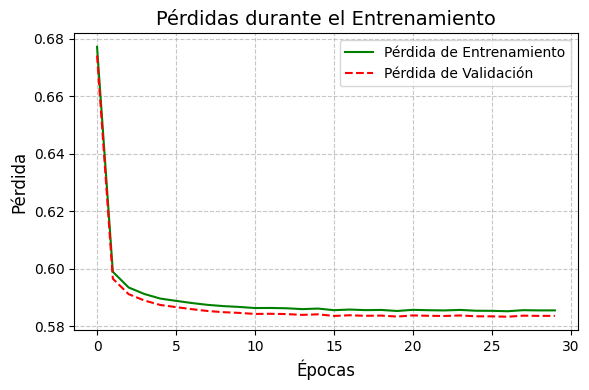

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Gráfico de pérdidas (Train vs Validation)
ax.plot(train_losses, label='Pérdida de Entrenamiento', color='green', linestyle='-')
ax.plot(valid_losses, label='Pérdida de Validación', color='red', linestyle='--')
ax.set_title('Pérdidas durante el Entrenamiento', fontsize=14)
ax.set_xlabel('Épocas', fontsize=12)
ax.set_ylabel('Pérdida', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

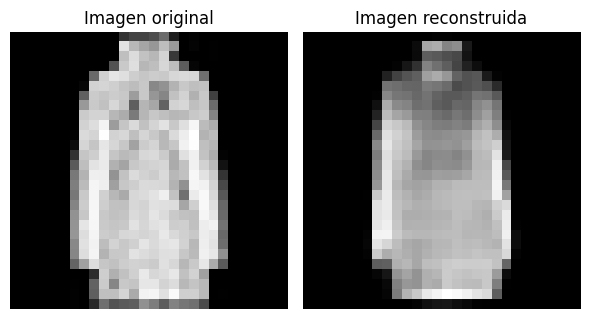

In [ ]:
# Inferencia con el modelo
output_tensor = model(image_with_channel)
output_image = output_tensor.detach().cpu().squeeze(0)  # Llevar a la CPU y eliminar el batch dimension

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Imagen original
axes[0].imshow(image.cpu().squeeze(), cmap="Greys_r")  # Llevar a la CPU para visualización
axes[0].axis("off")
axes[0].set_title("Imagen original")

# Imagen reconstruida
axes[1].imshow(output_image[0], cmap="Greys_r")  # Seleccionar canal 0
axes[1].axis("off")
axes[1].set_title("Imagen reconstruida")

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model, "autoencoder_model.pth")

##PARTE 3

In [ ]:
class Classifier(nn.Module):
    """
    Clasificador basado en el encoder del autoencoder preentrenado.
    """
    def __init__(self, encoder: nn.Module, encoder_output_shape: int,  num_classes: int, p: float):
        """
        Constructor del clasificador.

        Parámetros:
        - encoder (nn.Module): Encoder preentrenado del autoencoder.
        - num_classes (int): Número de clases para la clasificación.
        """
        super(Classifier, self).__init__()
        self.encoder = encoder  # Reutilizamos el encoder preentrenado

        # Capa de clasificación
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Aplana la salida del encoder
            nn.Linear(encoder_output_shape, 128),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(128, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define el flujo de datos para la clasificación.

        Parámetros:
        - x (torch.Tensor): Tensor de entrada con forma (batch_size, 1, 28, 28).

        Retorno:
        - torch.Tensor: Probabilidades de las clases (sin aplicar softmax).
        """
        # Paso por el encoder preentrenado
        features = self.encoder(x)

        # Paso por la capa de clasificación
        logits = self.classifier(features)

        return logits


In [ ]:
# Reutilizar el encoder preentrenado
pretrained_encoder = model.encoder

# Crear el clasificador
classifier = Classifier(encoder=pretrained_encoder, encoder_output_shape=model.encoder_output_shape, num_classes=10, p=0.5)

In [ ]:
def train_error_classification(model, train_loader, criterion, device):
  model.eval()  # Poner la red en modo de evaluación
  total_loss = 0
  correct = 0

  with torch.no_grad():  # Desactivar el cálculo de gradientes
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)

          output = model(data)  # Paso hacia adelante
          loss = criterion(output, target)  # Calcular la pérdida

          total_loss += loss.item()
          pred = output.argmax(dim=1, keepdim=True)  # Obtener predicciones
          correct += pred.eq(target.view_as(pred)).sum().item()

  avg_loss = total_loss / len(train_loader)
  accuracy = 100. * correct / len(train_loader.dataset)

  return avg_loss, accuracy


def train_loop_classification(model, train_loader, criterion, optimizer, device):
    model.train()  # Poner la red en modo de entrenamiento

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Limpiar gradientes previos
        output = model(data)  # Paso hacia adelante
        loss = criterion(output, target)  # Calcular la pérdida
        loss.backward()  # Paso hacia atrás
        optimizer.step()  # Actualizar los parámetros

    avg_loss, accuracy = train_error_classification(model, train_loader, criterion, device)
    return avg_loss, accuracy

def valid_loop_classification(model, valid_loader, criterion, device):
    model.eval()  # Poner la red en modo de evaluación
    total_loss = 0
    correct = 0

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)  # Paso hacia adelante
            loss = criterion(output, target)  # Calcular la pérdida

            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)  # Obtener predicciones
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = total_loss / len(valid_loader)
    accuracy = 100. * correct / len(valid_loader.dataset)

    return avg_loss, accuracy

In [ ]:
train_loader_classification = DataLoader(dataset=train_set_orig, batch_size=200, shuffle=True)
valid_loader_classification = DataLoader(dataset=test_set_orig, batch_size=200, shuffle=True)

In [ ]:
# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier.to(device)
print(f"Modelo trabajando en: {device}")

Modelo trabajando en: cuda


In [ ]:
num_epochs = 30
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    print(f"\nÉpoca {epoch}/{num_epochs}")

    # Entrenamiento
    train_loss, train_accuracy = train_loop_classification(classifier, train_loader_classification, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validación
    valid_loss, valid_accuracy = valid_loop_classification(classifier, valid_loader_classification, criterion, device)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f"Resumen - Época {epoch}:")
    print(f"  Pérdida de entrenamiento: {train_loss:.4f}")
    print(f"  Pérdida de validación: {valid_loss:.4f}, Precisión de validación: {valid_accuracy:.2f}%")

print("\nEntrenamiento finalizado.")


Época 1/30
Resumen - Época 1:
  Pérdida de entrenamiento: 0.3520
  Pérdida de validación: 0.3759, Precisión de validación: 87.45%

Época 2/30
Resumen - Época 2:
  Pérdida de entrenamiento: 0.2865
  Pérdida de validación: 0.3203, Precisión de validación: 88.60%

Época 3/30
Resumen - Época 3:
  Pérdida de entrenamiento: 0.2546
  Pérdida de validación: 0.2934, Precisión de validación: 89.14%

Época 4/30
Resumen - Época 4:
  Pérdida de entrenamiento: 0.2392
  Pérdida de validación: 0.2831, Precisión de validación: 89.63%

Época 5/30
Resumen - Época 5:
  Pérdida de entrenamiento: 0.2205
  Pérdida de validación: 0.2711, Precisión de validación: 89.91%

Época 6/30
Resumen - Época 6:
  Pérdida de entrenamiento: 0.2109
  Pérdida de validación: 0.2677, Precisión de validación: 90.09%

Época 7/30
Resumen - Época 7:
  Pérdida de entrenamiento: 0.2022
  Pérdida de validación: 0.2623, Precisión de validación: 90.32%

Época 8/30
Resumen - Época 8:
  Pérdida de entrenamiento: 0.1931
  Pérdida de vali

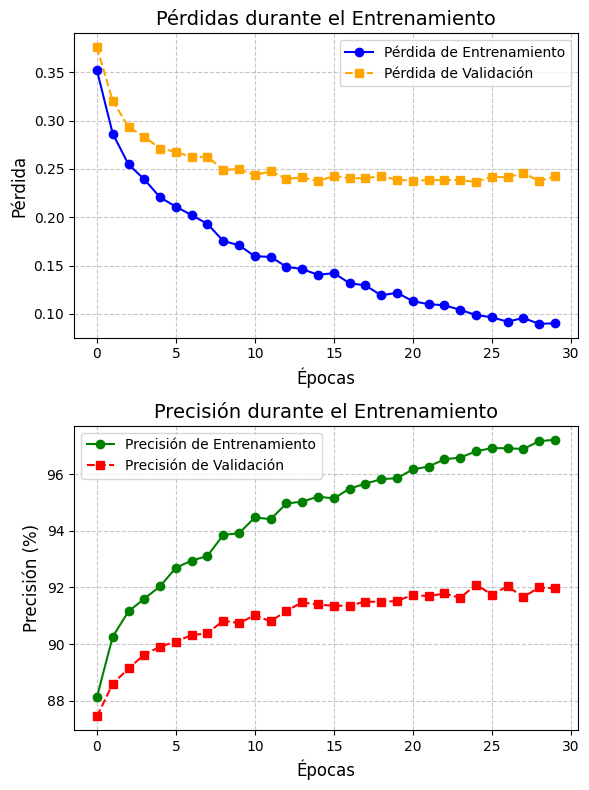

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# Gráfico de pérdidas (Train vs Validation)
ax[0].plot(train_losses, label='Pérdida de Entrenamiento', color='blue', linestyle='-', marker='o')
ax[0].plot(valid_losses, label='Pérdida de Validación', color='orange', linestyle='--', marker='s')
ax[0].set_title('Pérdidas durante el Entrenamiento', fontsize=14)
ax[0].set_xlabel('Épocas', fontsize=12)
ax[0].set_ylabel('Pérdida', fontsize=12)
ax[0].legend(fontsize=10)
ax[0].grid(True, linestyle='--', alpha=0.7)

# Gráfico de precisiones (Train vs Validation)
ax[1].plot(train_accuracies, label='Precisión de Entrenamiento', color='green', linestyle='-', marker='o')
ax[1].plot(valid_accuracies, label='Precisión de Validación', color='red', linestyle='--', marker='s')

ax[1].set_title('Precisión durante el Entrenamiento', fontsize=14)
ax[1].set_xlabel('Épocas', fontsize=12)
ax[1].set_ylabel('Precisión (%)', fontsize=12)
ax[1].legend(fontsize=10)
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [ ]:
torch.save(classifier, "classifier_model3.pth")

##PARTE 4

In [ ]:
# Congelar los parámetros del codificador
for param in classifier.encoder.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier.to(device)
print(f"Modelo trabajando en: {device}")

Modelo trabajando en: cuda


In [ ]:
num_epochs = 30
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    print(f"\nÉpoca {epoch}/{num_epochs}")

    # Entrenamiento
    train_loss, train_accuracy = train_loop_classification(classifier, train_loader_classification, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validación
    valid_loss, valid_accuracy = valid_loop_classification(classifier, valid_loader_classification, criterion, device)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f"Resumen - Época {epoch}:")
    print(f"  Pérdida de entrenamiento: {train_loss:.4f}")
    print(f"  Pérdida de validación: {valid_loss:.4f}, Precisión de validación: {valid_accuracy:.2f}%")

print("\nEntrenamiento finalizado.")


Época 1/30
Resumen - Época 1:
  Pérdida de entrenamiento: 0.0851
  Pérdida de validación: 0.2435, Precisión de validación: 92.05%

Época 2/30
Resumen - Época 2:
  Pérdida de entrenamiento: 0.0802
  Pérdida de validación: 0.2512, Precisión de validación: 92.07%

Época 3/30
Resumen - Época 3:
  Pérdida de entrenamiento: 0.0830
  Pérdida de validación: 0.2520, Precisión de validación: 92.26%

Época 4/30
Resumen - Época 4:
  Pérdida de entrenamiento: 0.0777
  Pérdida de validación: 0.2458, Precisión de validación: 92.13%

Época 5/30
Resumen - Época 5:
  Pérdida de entrenamiento: 0.0774
  Pérdida de validación: 0.2464, Precisión de validación: 91.86%

Época 6/30
Resumen - Época 6:
  Pérdida de entrenamiento: 0.0769
  Pérdida de validación: 0.2498, Precisión de validación: 92.01%

Época 7/30
Resumen - Época 7:
  Pérdida de entrenamiento: 0.0710
  Pérdida de validación: 0.2545, Precisión de validación: 92.17%

Época 8/30
Resumen - Época 8:
  Pérdida de entrenamiento: 0.0701
  Pérdida de vali

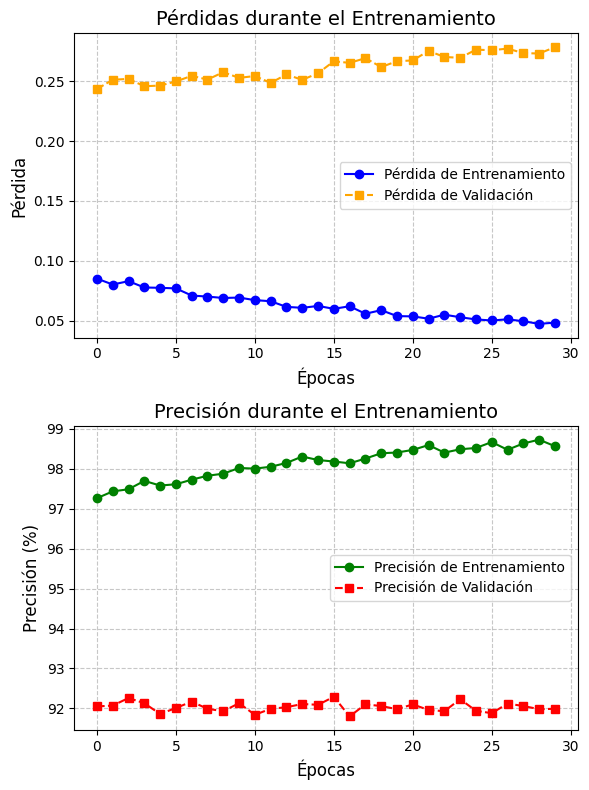

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# Gráfico de pérdidas (Train vs Validation)
ax[0].plot(train_losses, label='Pérdida de Entrenamiento', color='blue', linestyle='-', marker='o')
ax[0].plot(valid_losses, label='Pérdida de Validación', color='orange', linestyle='--', marker='s')
ax[0].set_title('Pérdidas durante el Entrenamiento', fontsize=14)
ax[0].set_xlabel('Épocas', fontsize=12)
ax[0].set_ylabel('Pérdida', fontsize=12)
ax[0].legend(fontsize=10)
ax[0].grid(True, linestyle='--', alpha=0.7)

# Gráfico de precisiones (Train vs Validation)
ax[1].plot(train_accuracies, label='Precisión de Entrenamiento', color='green', linestyle='-', marker='o')
ax[1].plot(valid_accuracies, label='Precisión de Validación', color='red', linestyle='--', marker='s')

ax[1].set_title('Precisión durante el Entrenamiento', fontsize=14)
ax[1].set_xlabel('Épocas', fontsize=12)
ax[1].set_ylabel('Precisión (%)', fontsize=12)
ax[1].legend(fontsize=10)
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [ ]:
torch.save(classifier, "classifier_model_retreained4.pth")

In [ ]:
params = [[0.5, nn.CrossEntropyLoss, optim.Adam, 10e-3, 200],
          [0.4, nn.CrossEntropyLoss, optim.Adam, 10e-2, 200],
          [0.5, nn.CrossEntropyLoss, optim.SGD, 10e-3, 200],
          [0.4, nn.CrossEntropyLoss, optim.SGD, 10e-3, 100],
          [0.5, nn.CrossEntropyLoss, optim.Adam, 10e-2, 100]]

Ftrain_losses = []
Fvalid_losses = []
Ftrain_accuracies = []
Fvalid_accuracies = []

for p in params:

    model = torch.load("autoencoder_model.pth")
    model.to("cuda")
    train_loader_classification = DataLoader(dataset=train_set_orig, batch_size=p[-1], shuffle=True)
    valid_loader_classification = DataLoader(dataset=test_set_orig, batch_size=p[-1], shuffle=True)

    pretrained_encoder = model.encoder
    # Crear el clasificador
    classifier = Classifier(encoder=pretrained_encoder, encoder_output_shape=model.encoder_output_shape, num_classes=10, p=p[0])
    classifier.to("cuda")
    # # Congelar los parámetros del codificador
    # for param in classifier.encoder.parameters():
    #     param.requires_grad = False

    num_epochs = 30
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    optimizer = p[2](classifier.parameters(), lr=p[3])

    for epoch in range(1, num_epochs + 1):
        print(f"\nÉpoca {epoch}/{num_epochs}")

        # Entrenamiento
        criterion = p[1]()  # Instancia la función de pérdida
        criterion.to("cuda")  # Asegúrate de moverla al dispositivo (opcional si no es necesario)

        train_loss, train_accuracy = train_loop_classification(classifier, train_loader_classification, criterion, optimizer, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validación
        valid_loss, valid_accuracy = valid_loop_classification(classifier, valid_loader_classification, criterion, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    Ftrain_losses.append(train_losses)
    Fvalid_losses.append(valid_losses)
    Ftrain_accuracies.append(train_accuracies)
    Fvalid_accuracies.append(valid_accuracies)

    print(f"Entrenamiento {p} finalizado.")

<ipython-input-37-4ae47bfded8d>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("autoencoder_model.pth")



Época 1/30

Época 2/30

Época 3/30

Época 4/30


KeyboardInterrupt: 

In [ ]:
params = [[0.5, nn.CrossEntropyLoss, optim.Adam, 10e-3, 200],
          [0.4, nn.CrossEntropyLoss, optim.Adam, 10e-2, 200],
          [0.5, nn.CrossEntropyLoss, optim.SGD, 10e-3, 200],
          [0.4, nn.CrossEntropyLoss, optim.SGD, 10e-3, 100],
          [0.5, nn.CrossEntropyLoss, optim.Adam, 10e-2, 100]]

Ftrain_losses = []
Fvalid_losses = []
Ftrain_accuracies = []
Fvalid_accuracies = []

for p in params:

    model = torch.load("autoencoder_model.pth")
    model.to("cuda")
    train_loader_classification = DataLoader(dataset=train_set_orig, batch_size=p[-1], shuffle=True)
    valid_loader_classification = DataLoader(dataset=test_set_orig, batch_size=p[-1], shuffle=True)

    pretrained_encoder = model.encoder
    # Crear el clasificador
    classifier = Classifier(encoder=pretrained_encoder, encoder_output_shape=model.encoder_output_shape, num_classes=10, p=p[0])
    classifier.to("cuda")
    # Congelar los parámetros del codificador
    for param in classifier.encoder.parameters():
        param.requires_grad = False

    num_epochs = 30
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    optimizer = p[2](classifier.parameters(), lr=p[3])

    for epoch in range(1, num_epochs + 1):
        print(f"\nÉpoca {epoch}/{num_epochs}")

        # Entrenamiento
        criterion = p[1]()  # Instancia la función de pérdida
        criterion.to("cuda")  # Asegúrate de moverla al dispositivo (opcional si no es necesario)

        train_loss, train_accuracy = train_loop_classification(classifier, train_loader_classification, criterion, optimizer, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validación
        valid_loss, valid_accuracy = valid_loop_classification(classifier, valid_loader_classification, criterion, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    Ftrain_losses.append(train_losses)
    Fvalid_losses.append(valid_losses)
    Ftrain_accuracies.append(train_accuracies)
    Fvalid_accuracies.append(valid_accuracies)

    print(f"Entrenamiento {p} finalizado.")

<ipython-input-38-10eaac6971a8>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("autoencoder_model.pth")



Época 1/30

Época 2/30

Época 3/30

Época 4/30

Época 5/30

Época 6/30

Época 7/30

Época 8/30

Época 9/30

Época 10/30

Época 11/30

Época 12/30

Época 13/30

Época 14/30

Época 15/30

Época 16/30

Época 17/30

Época 18/30

Época 19/30

Época 20/30

Época 21/30

Época 22/30

Época 23/30

Época 24/30

Época 25/30

Época 26/30

Época 27/30

Época 28/30

Época 29/30

Época 30/30
Entrenamiento [0.5, <class 'torch.nn.modules.loss.CrossEntropyLoss'>, <class 'torch.optim.adam.Adam'>, 0.01, 200] finalizado.

Época 1/30

Época 2/30

Época 3/30

Época 4/30

Época 5/30

Época 6/30

Época 7/30

Época 8/30

Época 9/30

Época 10/30

Época 11/30

Época 12/30

Época 13/30

Época 14/30

Época 15/30

Época 16/30

Época 17/30

Época 18/30

Época 19/30

Época 20/30

Época 21/30

Época 22/30

Época 23/30

Época 24/30

Época 25/30

Época 26/30

Época 27/30

Época 28/30

Época 29/30

Época 30/30
Entrenamiento [0.4, <class 'torch.nn.modules.loss.CrossEntropyLoss'>, <class 'torch.optim.adam.Adam'>, 0.1, 200]

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# Gráfico de pérdidas (Train vs Validation)
ax[0].plot(Ftrain_losses[0], label='Pérdida de Entrenamiento', color='blue', linestyle='-', marker='o')
ax[0].plot(Fvalid_losses[0], label='Pérdida de Validación', color='orange', linestyle='--', marker='s')
ax[0].set_title('Pérdidas durante el Entrenamiento', fontsize=14)
ax[0].set_xlabel('Épocas', fontsize=12)
ax[0].set_ylabel('Pérdida', fontsize=12)
ax[0].legend(fontsize=10)
ax[0].grid(True, linestyle='--', alpha=0.7)

# Gráfico de precisiones (Train vs Validation)
ax[1].plot(Ftrain_accuracies[0], label='Precisión de Entrenamiento', color='green', linestyle='-', marker='o')
ax[1].plot(Fvalid_accuracies[0], label='Precisión de Validación', color='red', linestyle='--', marker='s')

ax[1].set_title('Precisión durante el Entrenamiento', fontsize=14)
ax[1].set_xlabel('Épocas', fontsize=12)
ax[1].set_ylabel('Precisión (%)', fontsize=12)
ax[1].legend(fontsize=10)
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# Gráfico de pérdidas (Train vs Validation)
ax[0].plot(Ftrain_losses[1], label='Pérdida de Entrenamiento', color='blue', linestyle='-', marker='o')
ax[0].plot(Fvalid_losses[1], label='Pérdida de Validación', color='orange', linestyle='--', marker='s')
ax[0].set_title('Pérdidas durante el Entrenamiento', fontsize=14)
ax[0].set_xlabel('Épocas', fontsize=12)
ax[0].set_ylabel('Pérdida', fontsize=12)
ax[0].legend(fontsize=10)
ax[0].grid(True, linestyle='--', alpha=0.7)

# Gráfico de precisiones (Train vs Validation)
ax[1].plot(Ftrain_accuracies[1], label='Precisión de Entrenamiento', color='green', linestyle='-', marker='o')
ax[1].plot(Fvalid_accuracies[1], label='Precisión de Validación', color='red', linestyle='--', marker='s')

ax[1].set_title('Precisión durante el Entrenamiento', fontsize=14)
ax[1].set_xlabel('Épocas', fontsize=12)
ax[1].set_ylabel('Precisión (%)', fontsize=12)
ax[1].legend(fontsize=10)
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# Gráfico de pérdidas (Train vs Validation)
ax[0].plot(Ftrain_losses[2], label='Pérdida de Entrenamiento', color='blue', linestyle='-', marker='o')
ax[0].plot(Fvalid_losses[2], label='Pérdida de Validación', color='orange', linestyle='--', marker='s')
ax[0].set_title('Pérdidas durante el Entrenamiento', fontsize=14)
ax[0].set_xlabel('Épocas', fontsize=12)
ax[0].set_ylabel('Pérdida', fontsize=12)
ax[0].legend(fontsize=10)
ax[0].grid(True, linestyle='--', alpha=0.7)

# Gráfico de precisiones (Train vs Validation)
ax[1].plot(Ftrain_accuracies[2], label='Precisión de Entrenamiento', color='green', linestyle='-', marker='o')
ax[1].plot(Fvalid_accuracies[2], label='Precisión de Validación', color='red', linestyle='--', marker='s')

ax[1].set_title('Precisión durante el Entrenamiento', fontsize=14)
ax[1].set_xlabel('Épocas', fontsize=12)
ax[1].set_ylabel('Precisión (%)', fontsize=12)
ax[1].legend(fontsize=10)
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# Gráfico de pérdidas (Train vs Validation)
ax[0].plot(Ftrain_losses[3], label='Pérdida de Entrenamiento', color='blue', linestyle='-', marker='o')
ax[0].plot(Fvalid_losses[3], label='Pérdida de Validación', color='orange', linestyle='--', marker='s')
ax[0].set_title('Pérdidas durante el Entrenamiento', fontsize=14)
ax[0].set_xlabel('Épocas', fontsize=12)
ax[0].set_ylabel('Pérdida', fontsize=12)
ax[0].legend(fontsize=10)
ax[0].grid(True, linestyle='--', alpha=0.7)

# Gráfico de precisiones (Train vs Validation)
ax[1].plot(Ftrain_accuracies[3], label='Precisión de Entrenamiento', color='green', linestyle='-', marker='o')
ax[1].plot(Fvalid_accuracies[3], label='Precisión de Validación', color='red', linestyle='--', marker='s')

ax[1].set_title('Precisión durante el Entrenamiento', fontsize=14)
ax[1].set_xlabel('Épocas', fontsize=12)
ax[1].set_ylabel('Precisión (%)', fontsize=12)
ax[1].legend(fontsize=10)
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# Gráfico de pérdidas (Train vs Validation)
ax[0].plot(Ftrain_losses[4], label='Pérdida de Entrenamiento', color='blue', linestyle='-', marker='o')
ax[0].plot(Fvalid_losses[4], label='Pérdida de Validación', color='orange', linestyle='--', marker='s')
ax[0].set_title('Pérdidas durante el Entrenamiento', fontsize=14)
ax[0].set_xlabel('Épocas', fontsize=12)
ax[0].set_ylabel('Pérdida', fontsize=12)
ax[0].legend(fontsize=10)
ax[0].grid(True, linestyle='--', alpha=0.7)

# Gráfico de precisiones (Train vs Validation)
ax[1].plot(Ftrain_accuracies[4], label='Precisión de Entrenamiento', color='green', linestyle='-', marker='o')
ax[1].plot(Fvalid_accuracies[4], label='Precisión de Validación', color='red', linestyle='--', marker='s')

ax[1].set_title('Precisión durante el Entrenamiento', fontsize=14)
ax[1].set_xlabel('Épocas', fontsize=12)
ax[1].set_ylabel('Precisión (%)', fontsize=12)
ax[1].legend(fontsize=10)
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()